In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os
import matplotlib.pyplot as plt
import zlib
import sys
import compress
import random
import lzma

In [4]:
from compress import Compressor
c = Compressor()
c.use_zlib()

In [2]:
data_df = pd.read_csv('C1_160313.txt', sep=",", engine='python')
data_df.columns = ['Time', 'X', 'Y', 'Z']
# data_df.astype({'Y': 'float64'})

In [3]:
data_df = data_df.dropna()
data_df.isnull().sum()

Time    0
X       0
Y       0
Z       0
dtype: int64

In [4]:
data_df['X'] = round(data_df['X']/0.0078125)
data_df['Y'] = round(data_df['Y']/0.0078125)
data_df['Z'] = round(data_df['Z']/0.0078125)
data_df = data_df.astype({'X': 'int16',
               'Y': 'int16',
               'Z': 'int16'})
data_df.dtypes

Time    object
X        int16
Y        int16
Z        int16
dtype: object

In [5]:
data_df

,Time,X,Y,Z
0,1457857818.466883691,-1083,1085,579
1,1457857818.481750410,-1081,1091,586
2,1457857818.496617129,-1087,1089,590
3,1457857818.511483848,-1088,1151,571
4,1457857818.526350567,-1083,1177,566
...,...,...,...,...
724656,1457868591.660651464,-175,941,586
724657,1457868591.675518183,-179,956,580
724658,1457868591.690384902,-176,1019,562
724659,1457868591.705251621,-175,1039,574


In [6]:
data_df.isnull().sum()

Time    0
X       0
Y       0
Z       0
dtype: int64

In [7]:
data_df.dtypes

Time    object
X        int16
Y        int16
Z        int16
dtype: object

In [8]:
data_df = data_df.astype({'Time': 'float64'})
data_df.dtypes

Time    float64
X         int16
Y         int16
Z         int16
dtype: object

# 1 second, vary zlib level, measure final size of data (check time for compression later)
# ALSO THIS IS FOR SINGLE LIST COMPRESSION NOT 3D ARRAY

In [29]:
start = random.randint(0, 650000)
df_chunk = data_df[start: start+64]

In [69]:
time = np.array(df_chunk['Time'].tolist())
x_values = np.array(df_chunk['X'].tolist())
y_values = np.array(df_chunk['Y'].tolist())
z_values = np.array(df_chunk['Z'].tolist())
x_values

array([-65547, -65469, -65391, -65781, -65938, -65859, -65703, -65391,
       -65625, -65938, -65859, -66016, -65938, -65859, -65625, -65859,
       -66250, -65703, -65781, -65859, -65625, -65781, -65859, -66016,
       -66016, -66562, -66250, -66406, -66172, -66328, -66562, -66172,
       -66250, -66406, -66094, -66797, -66641, -66406, -66250, -66328,
       -66328, -66484, -66406, -66406, -66172, -66172, -66562, -66641,
       -65859, -66172, -66641, -66562, -66328, -66875, -66641, -66875,
       -66875, -66953, -66484, -66562, -66562, -66953, -66953, -66875])

In [117]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = zlib.compress(bytes(comp_x.encode('utf-8')), 9)
decomp_x = zlib.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)

True


In [120]:
def compressed_size(values_array, level):
    values = [str(x) for x in values_array]
    values_str = ','.join(values)
    initial = values_str.split(',')
    
    comp_values = zlib.compress(bytes(values_str.encode('utf-8')), level)
    decomp_values = zlib.decompress(comp_values).decode()
    final = decomp_values.split(',')
    if not initial == final:
        raise Exception('Decompressed does not equal compressed')
    return sys.getsizeof(comp_values)

In [190]:
# use zlib levels of 1, 5, 9
uncomp_values = []
comp_values1 = []
comp_values5 = []
comp_values9 = []

comp_values_t1 = []
comp_values_t5 = []
comp_values_t9 = []

comp_values_x1 = []
comp_values_x5 = []
comp_values_x9 = []

comp_values_y1 = []
comp_values_y5 = []
comp_values_y9 = []

comp_values_z1 = []
comp_values_z5 = []
comp_values_z9 = []

for i in range(10000):
    start = random.randint(0, 650000)
    df_chunk = data_df[start: start+64]
    
    time = np.array(df_chunk['Time'].tolist())
    x_values = np.array(df_chunk['X'].tolist())
    y_values = np.array(df_chunk['Y'].tolist())
    z_values = np.array(df_chunk['Z'].tolist())
    
    uncomp_values.append(sys.getsizeof(time) +
                        sys.getsizeof(x_values) +
                        sys.getsizeof(y_values) +
                        sys.getsizeof(z_values))
    
    comp_values_t1.append(compressed_size(time, 1))
    comp_values_t5.append(compressed_size(time, 5))
    comp_values_t9.append(compressed_size(time, 9))
    
    comp_values_x1.append(compressed_size(x_values, 1))
    comp_values_x5.append(compressed_size(x_values, 5))
    comp_values_x9.append(compressed_size(x_values, 9))
    
    comp_values_y1.append(compressed_size(y_values, 1))
    comp_values_y5.append(compressed_size(y_values, 5))
    comp_values_y9.append(compressed_size(y_values, 9))
    
    comp_values_z1.append(compressed_size(z_values, 1))
    comp_values_z5.append(compressed_size(z_values, 5))
    comp_values_z9.append(compressed_size(z_values, 9))
    
    total1 = sys.getsizeof(compressed_size(time, 1))+sys.getsizeof(compressed_size(x_values, 1))+sys.getsizeof(compressed_size(y_values, 1))+sys.getsizeof(compressed_size(z_values, 1))
    total5 = sys.getsizeof(compressed_size(time, 5))+sys.getsizeof(compressed_size(x_values, 5))+sys.getsizeof(compressed_size(y_values, 5))+sys.getsizeof(compressed_size(z_values, 5))
    total9 = sys.getsizeof(compressed_size(time, 9))+sys.getsizeof(compressed_size(x_values, 9))+sys.getsizeof(compressed_size(y_values, 9))+sys.getsizeof(compressed_size(z_values, 9))
    
    comp_values1.append(total1)
    
    comp_values5.append(total5)
    
    comp_values9.append(total9)
    

In [197]:
print(min(uncomp_values), max(uncomp_values))
print(min(comp_values1), max(comp_values1))
print(min(comp_values9), max(comp_values9))
print(min(comp_values9), max(comp_values9))

1664 1664
112 112
112 112
112 112


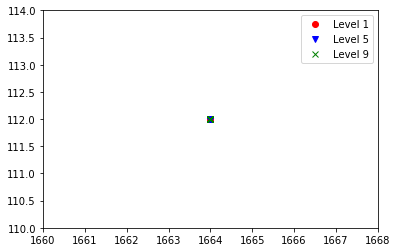

In [192]:
plt.plot(uncomp_values, comp_values1, 'ro', label='Level 1')
plt.plot(uncomp_values, comp_values5, 'bv', label='Level 5')
plt.plot(uncomp_values, comp_values9, 'gx', label='Level 9')
plt.axis([1660, 1668, 110, 114])
plt.legend()
plt.show()

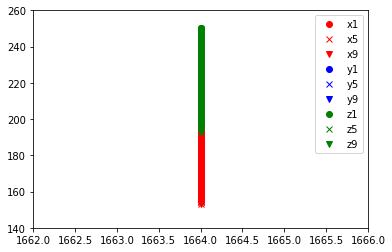

In [193]:
plt.plot(uncomp_values, comp_values_x1, 'ro', label='x1')
plt.plot(uncomp_values, comp_values_x5, 'rx', label='x5')
plt.plot(uncomp_values, comp_values_x9, 'rv', label='x9')
plt.plot(uncomp_values, comp_values_y1, 'bo', label='y1')
plt.plot(uncomp_values, comp_values_y5, 'bx', label='y5')
plt.plot(uncomp_values, comp_values_y9, 'bv', label='y9')
plt.plot(uncomp_values, comp_values_z1, 'go', label='z1')
plt.plot(uncomp_values, comp_values_z5, 'gx', label='z5')
plt.plot(uncomp_values, comp_values_z9, 'gv', label='z9')
plt.axis([1662, 1666, 140, 260])
plt.legend()
plt.show()

# LZMA

In [199]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = lzma.compress(bytes(comp_x.encode('utf-8')))
decomp_x = lzma.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)
print(sys.getsizeof(initial))
print(sys.getsizeof(comp_x))

True
576
277


In [171]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = snappy.compress(bytes(comp_x.encode('utf-8')))
decomp_x = snappy.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)
# print(initial)
# print(final)

AttributeError: module 'snappy' has no attribute 'compress'

# RANDOM

In [7]:
st = '1'
print(''.join('{0:014b}'.format(ord(x), 'b') for x in st))
print('{0:014b}'.format(-3))

00000000110001
-0000000000011


In [8]:
data_df.describe()

,X,Y,Z
count,710907.000000,710907.000000,710907.000000
mean,-798.749368,1045.176643,-100.195964
std,183.360972,478.466824,485.161339
min,-1279.000000,-485.000000,-1433.000000
25%,-883.000000,598.000000,-554.000000
50%,-822.000000,1046.000000,-99.000000
75%,-713.000000,1493.500000,354.000000
max,47.000000,2325.000000,1144.000000


In [11]:
t_values = data_df['Time'].tolist()
x_values = data_df['X'].tolist()
y_values = data_df['Y'].tolist()
z_values = data_df['Z'].tolist()
type(x_values)

list

In [10]:
def difference_coding(number_of_values, values, start_num):
    num_of_readings = number_of_values
    full_values = values[start_num: start_num + num_of_readings]
    

In [11]:
codes={}

def frequency (str) :
    freqs = {}
    for ch in str :
        freqs[ch] = freqs.get(ch,0) + 1
    return freqs

def sortFreq (freqs) :
    letters = freqs.keys()
    tuples = []
    for let in letters :
        tuples.append((freqs[let],let))
    tuples.sort()
    return tuples

def buildTree(tuples) :
    while len(tuples) > 1 :
        leastTwo = tuple(tuples[0:2])                  # get the 2 to combine
        theRest  = tuples[2:]                          # all the others
        combFreq = leastTwo[0][0] + leastTwo[1][0]     # the branch points freq
        tuples   = theRest + [(combFreq,leastTwo)]     # add branch point to the end
#         print(tuples)
        tuples.sort(key=lambda t: t[0])                                  # sort it into place
    return tuples[0]            # Return the single tree inside the list

def trimTree (tree) :
     # Trim the freq counters off, leaving just the letters
    p = tree[1]                                    # ignore freq count in [0]
    if type(p) == type("") : return p              # if just a leaf, return it
    else : return (trimTree(p[0]), trimTree(p[1])) # trim left then right and recombine
    
def assignCodes (node, pat='') :
    global codes
    if type(node) == type("") :
        codes[node] = pat                # A leaf. set its code
    else  :                              #
        assignCodes(node[0], pat+"0")    # Branch point. Do the left branch
        assignCodes(node[1], pat+"1")    # then do the right branch.

def encode_str (str) :
    global codes
    output = ""
    for ch in str : output += codes[ch]
    return output

def decode_str (tree, string_to_decode) :
    output = ""
    p = tree
    for bit in string_to_decode:
#         print(bit, type(bit), p)
        if bit == '0' : p = p[0]     # Head up the left branch
        else          : p = p[1]     # or up the right branch
        if type(p) == type("") :
            output += p              # found a character. Add to output
            p = tree                 # and restart for next character
    return output

original_str = 'aaabccdeeeeeffg'
qwe = frequency('aaabccdeeeeeffg')
print('frequencies:', qwe)
print('-'*20)
tuples_for_tree = sortFreq(qwe)
print('sorted freq:', tuples_for_tree)
print('-'*20)
tree = buildTree(tuples_for_tree)
print('tree:', tree)
print('-'*20)
trimmed = trimTree(tree)
print('trimmed tree:', trimmed)
print('-'*20)
assignCodes(trimmed)
print('assignment of codes:', codes)
print('-'*20)
print('encoded:', encode_str('aaabccdeeeeeffg'))
print('-'*20)
decoded = decode_str(trimmed, '000000101001101110111111111111100100010')
print('decoded:', decoded)
print('-'*20)
print('Original matches decoded:', decoded == original_str)

frequencies: {'a': 3, 'b': 1, 'c': 2, 'd': 1, 'e': 5, 'f': 2, 'g': 1}
--------------------
sorted freq: [(1, 'b'), (1, 'd'), (1, 'g'), (2, 'c'), (2, 'f'), (3, 'a'), (5, 'e')]
--------------------
tree: (15, ((6, ((3, 'a'), (3, ((1, 'g'), (2, 'c'))))), (9, ((4, ((2, 'f'), (2, ((1, 'b'), (1, 'd'))))), (5, 'e')))))
--------------------
trimmed tree: (('a', ('g', 'c')), (('f', ('b', 'd')), 'e'))
--------------------
assignment of codes: {'a': '00', 'g': '010', 'c': '011', 'f': '100', 'b': '1010', 'd': '1011', 'e': '11'}
--------------------
encoded: 000000101001101110111111111111100100010
--------------------
decoded: aaabccdeeeeeffg
--------------------
Original matches decoded: True


In [13]:
start = random.randint(0, 650000)
num_of_readings = 70
initial = x_values[start]
full_values = x_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(x_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
print('Calculated Differences size:', sys.getsizeof(final_str))
print('Actual calculated differences string:', final_str)
print('--'*20)
print('Uncompressed size:', sys.getsizeof(full_joined))
print('Full uncompressed string:', full_joined)
print('--'*20)
# print(sys.getsizeof(final_str.encode('utf-8')), final_str.encode('utf-8'))
# print('--'*20)
print('zlib compressed size:', sys.getsizeof(zlib.compress(final_str.encode('utf-8'))))
print('--'*20)
codes={}
qwe = frequency(final_str)
tuples_for_tree = sortFreq(qwe)
tree = buildTree(tuples_for_tree)
trimmed = trimTree(tree)
assignCodes(trimmed)
encoded = encode_str(final_str)
decoded = decode_str(trimmed, encoded)
# print(codes)
print('encoded:', encoded)
print('length of huffman encoded in bits?:', len(encoded))
print('length in bytes:', len(encoded)/8)
print('huffman encoded size:', sys.getsizeof(encoded.encode('utf-8')))
print('Original matches decoded:', decoded == final_str)
# print('decoded:', decoded)
# print('bytes form:', bytes(encoded.encode('utf-8')))

Calculated Differences size: 279
Actual calculated differences string: -656:0,1,-7,-3,0,-5,0,-3,1,-6,-8,-9,-12,-8,-9,-8,-8,0,-5,-8,-13,-14,-8,-16,-15,-9,-10,-15,-12,-13,-16,-9,-9,-8,-13,-16,-21,-19,-21,-21,-16,-18,-16,-17,-23,-24,-28,-29,-29,-33,-33,-32,-25,-28,-28,-32,-32,-33,-32,-29,-32,-37,-32,-30,-26,-24,-25,-26,-28,-25
----------------------------------------
Uncompressed size: 374
Full uncompressed string: -656,-655,-663,-659,-656,-661,-656,-659,-655,-662,-664,-665,-668,-664,-665,-664,-664,-656,-661,-664,-669,-670,-664,-672,-671,-665,-666,-671,-668,-669,-672,-665,-665,-664,-669,-672,-677,-675,-677,-677,-672,-674,-672,-673,-679,-680,-684,-685,-685,-689,-689,-688,-681,-684,-684,-688,-688,-689,-688,-685,-688,-693,-688,-686,-682,-680,-681,-682,-684,-681
----------------------------------------
zlib compressed size: 129
----------------------------------------
encoded: 010000110100000110011011000101111100111001010011110101100010011101010110001001111010111110010000100100011001110111001

Graphs for 400 Readings


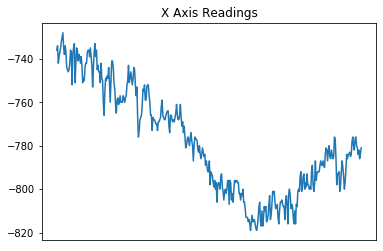

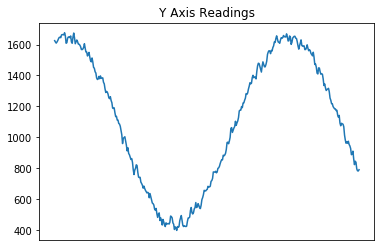

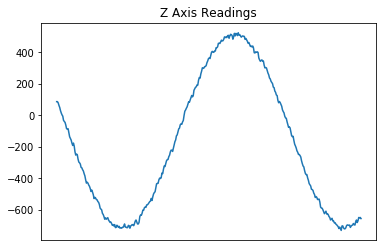

In [10]:
rand_start = random.randint(0, 650000)
df_part = data_df[rand_start: rand_start+400]
print('Graphs for 400 Readings')
plt.plot(df_part['Time'], df_part['X'])
plt.xticks([])
plt.title('X Axis Readings')
plt.show()

plt.plot(df_part['Time'], df_part['Y'])
plt.xticks([])
plt.title('Y Axis Readings')
plt.show()

plt.plot(df_part['Time'], df_part['Z'])
plt.xticks([])
plt.title('Z Axis Readings')
plt.show()

In [14]:
int('0100001101000001100110110001011111001110010100111101011000100111010101100010011110101111100100001001000110011101110011111001100100011001110111001000110010001101100010011101010010001100111111110100111111100111100100011001111100001001111111010100111011100111111100010011111110101001111100110011111111010011111000010011101110011101110010001100111111110100111110000100100111111001111111011100100111111001001111110011111000010011111000110011111000010011111110010100100111101001001110011110010010001100100111011100100111011100111101110100111101110100111100011001001110101001001000110010010001100111100011001111000110011110111010011110001100100111011100111100011001111011001010011110001100111101100010010010000100100111001111001001110101001001000010010010001100100111010', 2)

12746164589062952870982769233386913477817926023523623223540386838358220628672661651969741259020611321649623928942294939996160139210049120563437629932887981377355233519296111456746886251098529723172294506438121906081501523296721210

In [23]:
# this is from rosetta codes implementation of run length encoding
# http://rosettacode.org/wiki/Run-length_encoding#Python
def rle_encode(input_string):
    count = 1
    prev = ''
    lst = []
    for character in input_string:
        if character != prev:
            if prev:
                entry = (prev,count)
                lst.append(entry)
                #print lst
            count = 1
            prev = character
        else:
            count += 1
    else:
        try:
            entry = (character,count)
            lst.append(entry)
            return (lst, 0)
        except Exception as e:
            print("Exception encountered {e}".format(e=e)) 
            return (e, 1)
        
def rle_decode(lst):
    q = ""
    for character, count in lst:
        q += character * count
    return q
 
#Method call
value = rle_encode("aaaaahhhhhhmmmmmmmuiiiiiiiaaaaaa")
if value[1] == 0:
    print("Encoded value is {}".format(value[0]))
    rle_decode(value[0])
rle_decode(value[0])

huffman_encoded = '0100001101000001100110110001011111001110010100111101011000100111010101100010011110101111100100001001000110011101110011111001100100011001110111001000110010001101100010011101010010001100111111110100111111100111100100011001111100001001111111010100111011100111111100010011111110101001111100110011111111010011111000010011101110011101110010001100111111110100111110000100100111111001111111011100100111111001001111110011111000010011111000110011111000010011111110010100100111101001001110011110010010001100100111011100100111011100111101110100111101110100111100011001001110101001001000110010010001100111100011001111000110011110111010011110001100100111011100111100011001111011001010011110001100111101100010010010000100100111001111001001110101001001000010010010001100100111010'
value = rle_encode(huffman_encoded)
# print(value)
print(rle_decode(value[0]) == huffman_encoded)

Encoded value is [('a', 5), ('h', 6), ('m', 7), ('u', 1), ('i', 7), ('a', 6)]
True


In [50]:
# this is from https://stackabuse.com/run-length-encoding/
# RUN LENGTH ENCODING

def rle_encode(data):
    encoding = ''
    prev_char = ''
    count = 1

    if not data: return ''

    for char in data:
        # If the prev and current characters
        # don't match...
        if char != prev_char:
            # ...then add the count and character
            # to our encoding
            if prev_char:
                encoding += str(count) + prev_char
            count = 1
            prev_char = char
        else:
            # Or increment our counter
            # if the characters do match
            count += 1
    else:
        # Finish off the encoding
        encoding += str(count) + prev_char
        return encoding
    
encoded_val = rle_encode(huffman_encoded)

def rle_decode(data):
    decode = ''
    count = 1
    for char in data:
#         print('char', char)
        # If the character is numerical...
        if int(char) > 1:
            # ...append it to our count
            count += int(char)
        else:
            # Otherwise we've seen a non-numerical
            # character and need to expand it for
            # the decoding
#             print('count', count)
            decode += char * int(count)
            count = 1
    return decode

decoded_val = rle_decode(encoded_val)

print(sys.getsizeof(encoded_val), encoded_val)
print(sys.getsizeof(decoded_val))
# print(decoded_val)
# print('here')

715 101140211011502120211021301110512031201110112041101110213011203110111011102130112041101110512011401120113021203110312051202120113021203110312011302120113021102130112031101110112011302120811011207120412011302120514011207110111011203110312071301120711011101120512021208110112051401120311031203110312011302120811011205140112011206120711031201120612011206120514011205130212051401120712011101120112041101120112031204120112011302120112031103120112031103120411031101120411031101120413021201120311011101120112011302120112011302120413021204130212041103110112041302120112031103120413021204110212011101120413021204110213011201120114011201120312041201120311011101120112011401120112011302120112031101110
1133


In [46]:
start = random.randint(0, 650000)
num_of_readings = 20
initial = x_values[start]
full_values = x_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(x_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
# print(new)
absx_values = [abs(x) for x in new]
print('Max x value:', max(absx_values))



initial = y_values[start]
full_values = y_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(y_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
# print(new)
absy_values = [abs(x) for x in new]
print('Max y value:', max(absy_values))



initial = z_values[start]
full_values = z_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(z_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
# print(new)
absz_values = [abs(x) for x in new]
print('Max z value:', max(absz_values))

def bits_required(list_of_abs):
    if max(list_of_abs) < 2:
        return 1
    if max(list_of_abs) < 4:
        return 2
    if max(list_of_abs) < 8:
        return 3
    if max(list_of_abs) < 16:
        return 4
    if max(list_of_abs) < 32:
        return 5
    if max(list_of_abs) < 64:
        return 6
    if max(list_of_abs) < 128:
        return 7
    if max(list_of_abs) < 256:
        return 8
    if max(list_of_abs) < 512:
        return 9
    if max(list_of_abs) < 1024:
        return 10
    if max(list_of_abs) < 2048:
        return 11
    
print('Bits required for x:', bits_required(absx_values))
print('Bits required for y:', bits_required(absy_values))
print('Bits required for z:', bits_required(absz_values))

Max x value: 15
Max y value: 87
Max z value: 237
Bits required for x: 4
Bits required for y: 7
Bits required for z: 8


In [104]:
x_bits = []
y_bits = []
z_bits = []

for i in range(10000):
    start = random.randint(0, 650000)
    num_of_readings = 70
    initial = x_values[start]
    full_values = x_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    new = []
    for i in range(start, start+num_of_readings):
        new.append(x_values[i]-initial)

    lst_joined = ','.join(map(str, new))
    final_str = str(initial)+':'+lst_joined
    # print(new)
    absx_values = [abs(x) for x in new]
    # print('Max x value:', max(absx_values))



    initial = y_values[start]
    full_values = y_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    new = []
    for i in range(start, start+num_of_readings):
        new.append(y_values[i]-initial)

    lst_joined = ','.join(map(str, new))
    final_str = str(initial)+':'+lst_joined
    # print(new)
    absy_values = [abs(x) for x in new]
    # print('Max y value:', max(absy_values))



    initial = z_values[start]
    full_values = z_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    new = []
    for i in range(start, start+num_of_readings):
        new.append(z_values[i]-initial)

    lst_joined = ','.join(map(str, new))
    final_str = str(initial)+':'+lst_joined
    # print(new)
    absz_values = [abs(x) for x in new]
    # print('Max z value:', max(absz_values))

    x_bits.append(bits_required(absx_values))
    y_bits.append(bits_required(absy_values))
    z_bits.append(bits_required(absz_values))

In [105]:
# x_bits

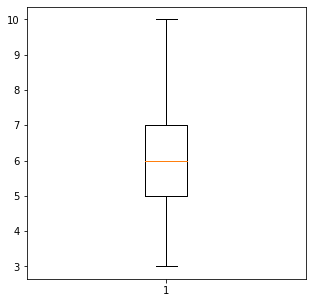

In [106]:
plt.boxplot(x_bits)
# plt.boxplot(y_bits)
# plt.boxplot(z_bits)
plt.show()

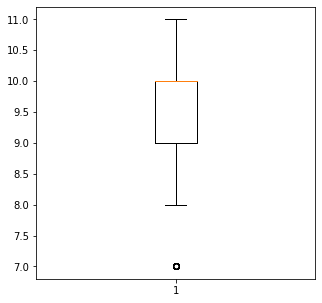

In [107]:
plt.boxplot(y_bits)
plt.show()

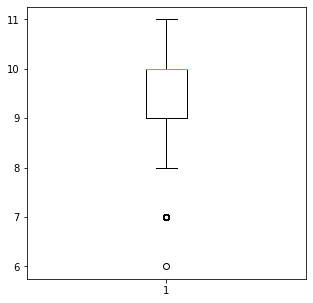

In [108]:
plt.boxplot(z_bits)
plt.show()

In [109]:
bits_df = pd.DataFrame(data=list(zip(x_bits, y_bits, z_bits)), columns=['x_bits', 'y_bits', 'z_bits'])
bits_df

,x_bits,y_bits,z_bits
0,6,8,10
1,5,10,10
2,9,10,10
3,8,9,11
4,7,10,9
...,...,...,...
9995,7,10,9
9996,5,8,10
9997,4,10,10
9998,7,10,9


In [110]:
bits_df['total_bits'] = bits_df['x_bits'] + bits_df['y_bits'] + bits_df['z_bits']
bits_df

,x_bits,y_bits,z_bits,total_bits
0,6,8,10,24
1,5,10,10,25
2,9,10,10,29
3,8,9,11,28
4,7,10,9,26
...,...,...,...,...
9995,7,10,9,26
9996,5,8,10,23
9997,4,10,10,24
9998,7,10,9,26


In [111]:
bits_df['50_samples'] = 42 + bits_df['total_bits']*49
bits_df['100_samples'] = 42 + bits_df['total_bits']*99
bits_df['150_samples'] = 42 + bits_df['total_bits']*149
bits_df['200_samples'] = 42 + bits_df['total_bits']*199
bits_df['250_samples'] = 42 + bits_df['total_bits']*249
bits_df['300_samples'] = 42 + bits_df['total_bits']*299
bits_df['350_samples'] = 42 + bits_df['total_bits']*349
bits_df

,x_bits,y_bits,z_bits,total_bits,50_samples,100_samples,150_samples,200_samples,250_samples,300_samples,350_samples
0,6,8,10,24,1218,2418,3618,4818,6018,7218,8418
1,5,10,10,25,1267,2517,3767,5017,6267,7517,8767
2,9,10,10,29,1463,2913,4363,5813,7263,8713,10163
3,8,9,11,28,1414,2814,4214,5614,7014,8414,9814
4,7,10,9,26,1316,2616,3916,5216,6516,7816,9116
...,...,...,...,...,...,...,...,...,...,...,...
9995,7,10,9,26,1316,2616,3916,5216,6516,7816,9116
9996,5,8,10,23,1169,2319,3469,4619,5769,6919,8069
9997,4,10,10,24,1218,2418,3618,4818,6018,7218,8418
9998,7,10,9,26,1316,2616,3916,5216,6516,7816,9116


In [112]:
# what about sign? does it require an extra bit?
# uc = uncompressed
bits_df['50_uc'] = 42*50
bits_df['100_uc'] = 42*100
bits_df['150_uc'] = 42*150
bits_df['200_uc'] = 42*200
bits_df['250_uc'] = 42*250
bits_df['300_uc'] = 42*300
bits_df['350_uc'] = 42*350
bits_df

,x_bits,y_bits,z_bits,total_bits,50_samples,100_samples,150_samples,200_samples,250_samples,300_samples,350_samples,50_uc,100_uc,150_uc,200_uc,250_uc,300_uc,350_uc
0,6,8,10,24,1218,2418,3618,4818,6018,7218,8418,2100,4200,6300,8400,10500,12600,14700
1,5,10,10,25,1267,2517,3767,5017,6267,7517,8767,2100,4200,6300,8400,10500,12600,14700
2,9,10,10,29,1463,2913,4363,5813,7263,8713,10163,2100,4200,6300,8400,10500,12600,14700
3,8,9,11,28,1414,2814,4214,5614,7014,8414,9814,2100,4200,6300,8400,10500,12600,14700
4,7,10,9,26,1316,2616,3916,5216,6516,7816,9116,2100,4200,6300,8400,10500,12600,14700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,10,9,26,1316,2616,3916,5216,6516,7816,9116,2100,4200,6300,8400,10500,12600,14700
9996,5,8,10,23,1169,2319,3469,4619,5769,6919,8069,2100,4200,6300,8400,10500,12600,14700
9997,4,10,10,24,1218,2418,3618,4818,6018,7218,8418,2100,4200,6300,8400,10500,12600,14700
9998,7,10,9,26,1316,2616,3916,5216,6516,7816,9116,2100,4200,6300,8400,10500,12600,14700


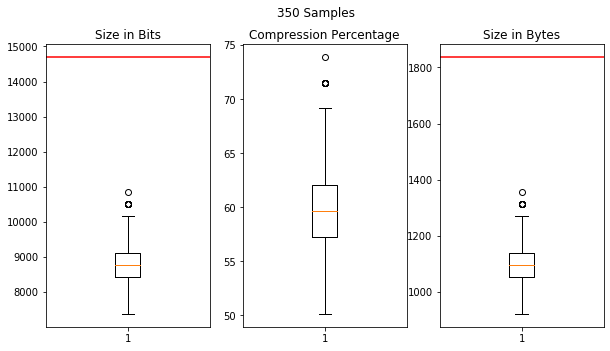

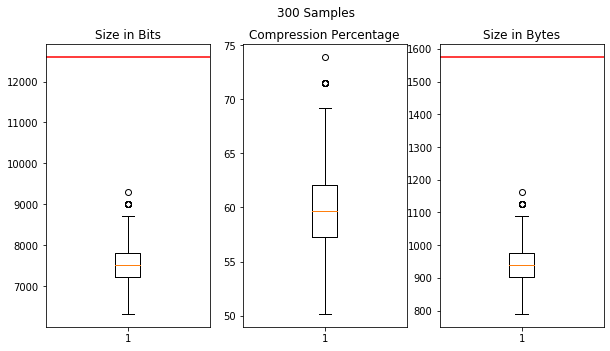

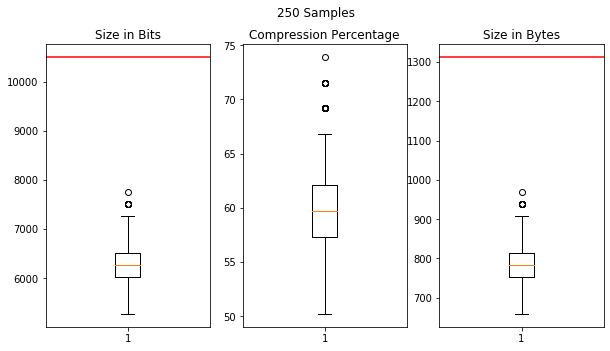

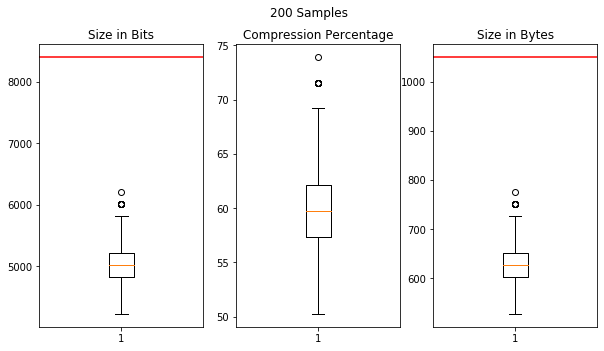

In [148]:
from pylab import rcParams
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = 10, 5.2 # width, height (both in inches)
gs = gridspec.GridSpec(1, 3) # 1 row, 3 columns

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df['350_samples'])
ax.axhline(y=bits_df['350_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df['350_samples']*100/bits_df['350_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df['350_samples']/8)
ax3.axhline(y=bits_df['350_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('350 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df['300_samples'])
ax.axhline(y=bits_df['300_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df['300_samples']*100/bits_df['300_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df['300_samples']/8)
ax3.axhline(y=bits_df['300_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('300 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df['250_samples'])
ax.axhline(y=bits_df['250_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df['250_samples']*100/bits_df['250_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df['250_samples']/8)
ax3.axhline(y=bits_df['250_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('250 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0]) # row, column
ax.boxplot(bits_df['200_samples'])
ax.axhline(y=bits_df['200_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df['200_samples']*100/bits_df['200_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df['200_samples']/8)
ax3.axhline(y=bits_df['200_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('200 Samples')
plt.show()